# Importing Real Estate Data from immoscout24.ch

This notebook contains code that can pull data on real estate prices, number of rooms and square meters for listings on the Swiss website immoscout24.ch for a desired Swiss state. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import requests
from bs4 import BeautifulSoup

Specify the state for which to scrap real estate data from and the total number of pages.

In [2]:
state = "aargau"
ptot = 42

Set the url for the first page of results for the desired state

In [3]:
URL = f"https://www.immoscout24.ch/en/real-estate/buy/canton-{state}"

Create function that reads the html page and store relevant information

In [4]:
def soup_from_state(URL):
    """Return soup element from url"""
    page = requests.get(URL)  
    soup = BeautifulSoup(page.content, "html.parser")  
    return soup
    
def add_data(
    data, 
    soup,
    tag="h3",
    class_="Box-cYFBPY edGgnU Heading-dlrjyy bVzSiN",
):
    """Find all prices in the html and store in DataFrame """
    
    # Find all info in the <span> within the <tag> of class "class"
    job_elements = soup.find_all(tag, class_=class_)

    for job_element in job_elements:
        
        # Price in CHF
        if job_element.span.text[0] != 'P':
            # convert price in format "CHF x,xxx,xxx.-"" to float
            price = float(re.search(
                'CHF ([0-9,]*\.[0-9]*)', job_element.span.text).group(1).replace(',', ''))
        else:
            price = np.nan
        
        # Number of rooms and square meters
        if ('rooms' not in job_element.text) and ('m²' in job_element.text):
            rooms = np.nan
            m2 = re.split(' rooms,| m²', job_element.text)[0]
        elif 'rooms' and 'm²' in job_element.text:
            rooms = re.split(' rooms,| m²', job_element.text)[0]
            m2 = re.split(' rooms,| m²', job_element.text)[1]
        elif ('rooms' in job_element.text) and ('m²' not in job_element.text):
            rooms = re.split(' rooms', job_element.text)[0]
            m2 = np.nan
        else:
            rooms, m2 = np.nan, np.nan
        
        # Store in data
        data = data.append(
            pd.DataFrame([price, rooms, m2], index=['price', 'rooms', 'm2']).T
        )
        
    return data

Create empty dataset

In [5]:
data = pd.DataFrame(
    columns=['price', 'rooms', 'm2']
)

Import the web page in html format and parse

In [6]:
soup = soup_from_state(URL)
data = add_data(data, soup)

Do it for all pages 

In [7]:
for pagenb in range(1, ptot+1, 1):
    if not pagenb%10: 
        print(f'Page {pagenb}/{ptot}')
    soup = soup_from_state(URL + '?pn=' + str(pagenb))
    data = add_data(data, soup)  # Store data of next page

Page 10/42
Page 20/42
Page 30/42
Page 40/42


Summary statistics on prices

In [8]:
print(f"N:      {float(data['price'].count()):.0f}")
print(f"Mean:   {float(data['price'].mean()):.0f}")
print(f"Median: {float(data['price'].median()):.0f}")
print(f"Min:    {float(data['price'].min()):.0f}")
print(f"Max:    {float(data['price'].max()):.0f}")
print(f"Std:    {float(data['price'].std()):.0f}")

N:      939
Mean:   987500
Median: 870000
Min:    195000
Max:    4395000
Std:    492877


Visualize distribution of prices

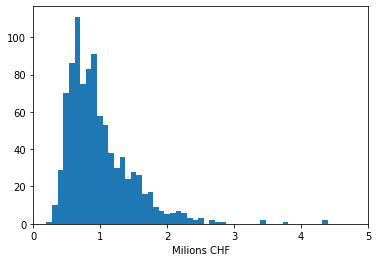

In [9]:
plt.hist(data['price']/1e6, bins=50)
plt.xlabel('Milions CHF')
plt.xlim(0, 5)
plt.show()